# Classic ML models

## Set up

### Install libraries

In [110]:
!pip install nltk
!pip install empath
!pip install iterative-stratification

### Import libraries

In [111]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import nltk
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from nltk.corpus import stopwords
import collections
from collections import Counter
from nltk.tag import pos_tag
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report,f1_score,roc_auc_score,plot_confusion_matrix,recall_score
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from sklearn.utils import resample
from sklearn.exceptions import ConvergenceWarning
import empath
import warnings  

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=ConvergenceWarning)
pd.options.mode.chained_assignment = None

## Functions

#### Preprocess

##### Utils

In [112]:
def inverse_frequency(df):
    neg, pos = np.bincount(df["PHQ8_Binary"])
    total = neg + pos
    print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
        total, pos, 100 * pos / total))

    weight_for_0 = (1 / (neg / total))
    weight_for_1 = (1 / (pos / total))

    class_weight = {0: weight_for_0, 1: weight_for_1}

  #initial_bias = np.log([pos/neg])

    return class_weight

def clean_text(text):
    cleaned_text = re.sub(r"\s+\.", ".", text)  # Remove the space before the period
    cleaned_text = re.sub(r"[^\w\s,.?!]", "", cleaned_text)  # Remove non-alphanumeric characters except for , . ? !
    return cleaned_text



def random_oversample(df,seed):
    # Separate the data based on class (assuming 'label' is the class column)
    # with 1 being the positive (minority) class
    df_minority = df[df['PHQ8_Binary'] == 1]
    df_majority = df[df['PHQ8_Binary'] == 0]

    # Perform oversampling on the minority class
    df_minority_oversampled = resample(df_minority,
                                      replace=True, # sample with replacement
                                      n_samples=int(len(df_majority)*0.95), # match number in majority class
                                      random_state=seed) # reproducible results

    # Combine the majority class with the oversampled minority class
    df_oversampled = pd.concat([df_majority, df_minority_oversampled])

    return df_oversampled

##### Dataset

In [113]:
# Function to count first-person pronouns
def count_first_person_pronouns(text):
    tokens = nltk.word_tokenize(text.lower())
    pronouns = ['i', 'me', 'my', 'mine', 'we', 'us', 'our', 'ours']
    count = sum(token in pronouns for token in tokens)
    return count

# Function to count adjectives
def count_adjectives(text):
    tokens = nltk.word_tokenize(text.lower())
    tagged_tokens = pos_tag(tokens)
    count = sum(tag.startswith('JJ') for _, tag in tagged_tokens)
    return count

# Function to count verbs for each tense
def count_past_verbs(text):
    tokens = nltk.word_tokenize(text.lower())
    tagged_tokens = pos_tag(tokens)
    verb_tags = [tag for _, tag in tagged_tokens if tag.startswith('V')]
    past = 0
    for tag in verb_tags:
        if tag in ['VBD', 'VBN']:
            past += 1
        
    return past

def count_present_verbs(text):
    tokens = nltk.word_tokenize(text.lower())
    tagged_tokens = pos_tag(tokens)
    verb_tags = [tag for _, tag in tagged_tokens if tag.startswith('V')]
    present = 0
    for tag in verb_tags:
        if tag in ['VBP', 'VBZ','VBG']:
            present += 1
            
    return present

def count_filler_words(text):
    tokens = nltk.word_tokenize(text.lower())
    filler_words = ['um', 'uh', 'uhmm', 'like', 'you know','well']
    count = sum(token in filler_words for token in tokens)
    return count


def word_cats(data):
    lexicon = empath.Empath() 
    features = []
    
    for text in data['intervention']:
        result = lexicon.analyze(text)
        features.append(result)

    # Create new columns in the dataframe for each category score
    for category in lexicon.cats:
        data[category] = [result.get(category, 0.0) for result in features]
    

    # Important to delete for only 0 columns
    data = data.loc[:, (data != 0).any(axis=0)]
    return data

def preprocess(data):
    data = word_cats(data)
    data['first_person_pronoun_count'] = data['intervention'].apply(count_first_person_pronouns)
    data['adjective_count'] = data['intervention'].apply(count_adjectives)
    data['filler_word_count'] = data['intervention'].apply(count_filler_words)
    data['present'] = data['intervention'].apply(count_present_verbs)
    data['past'] = data['intervention'].apply(count_past_verbs)
    return data

### Splitting function

In [114]:
def split_dataset(df, test_size=0.15, val_size=0.2, random_state=42):
    """
      Function that splits a df taking in consideration balancing o Gender, PHQ and length of intervention.

      Params
      ---
        -df: The data to split
        -test_size: the size of the test set
        -val_size: the size of the validation set out of the remaining set after extracting the test set.
        -random_state: The seed, for reproducibility

      Returns
      ---
        - The same dataframe with a column name 'split' that indicates where each data point corresponds

    """
    # Ensure the 'gender' column is numerical
    if df['Gender'].dtype == 'object':
        df['Gender'] = df['Gender'].astype('category').cat.codes

    # Combine the 'gender' and 'label' columns into a new 2D array
    y = df[['Gender', 'PHQ8_Binary']].values


    try:
      # Split the DataFrame into three equal parts representing short, medium, and long texts
        labels=['short', 'medium', 'long']
        df['text_length_category'] = pd.qcut(df['word_count'], 3, labels=labels)
    except:
        labels=['short', 'long']
        # Split into 'short' and 'long' based on the median
        median = df['word_count'].median()
        df['text_length_category'] = np.where(df['word_count'] <= median, 'short', 'long')


    df_train = pd.DataFrame()
    df_test = pd.DataFrame()
    
    
    df_columns_to_drop = ['id', 'intervention', 'question', 'start_time', 'end_time',
       'question_text', 'Gender', 'PHQ8_Score', 'PHQ8_Binary', 'split',
       'word_count','text_length_category']
    # Loop over each category
    for category in labels:
        df_temp = df[df['text_length_category'] == category]

        # Create the initial splitter
        initial_split = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)

        # Split out the test set
        for other_index, test_index in initial_split.split(df_temp, df_temp[['Gender', 'PHQ8_Binary']].values):
            df_train_, df_test_ = df_temp.iloc[other_index], df_temp.iloc[test_index]
        
        
        df_train = pd.concat([df_train.copy(),df_train_])
        df_test = pd.concat([df_test.copy(),df_test_])

    df_train = df_train.dropna()
    df_test = df_test.dropna()
    
    y_train,x_train = df_train["PHQ8_Binary"], df_train.drop(df_columns_to_drop,axis=1)
    y_test,x_test = df_test["PHQ8_Binary"], df_test.drop(df_columns_to_drop,axis=1)

    return x_train,y_train,x_test,y_test

#### Define the datasets

In [115]:
#data = pd.read_csv("/content/gdrive/MyDrive/daiwoz/data_per_interval.csv",index_col=0).reset_index().rename(columns={"value":"intervention","id":"patient_id","index":"id"})

data = pd.read_csv("best_questions.csv",index_col=0)
data["question"] = data.question + 1

data

,id,intervention,question,start_time,end_time,question_text,Gender,PHQ8_Score,PHQ8_Binary,split,word_count
0,300,good,1,62.328,63.178,how are you doing today,1,2,0,test,1
1,300,um probably about two weeks ago. uh frustrated...,2,227.998,267.988,when was the last time you argued with someone...,1,2,0,test,31
2,300,i'm i'm i'm pretty good at it um. yeah,3,217.728,222.068,how are you at controlling your temper,1,2,0,test,9
3,300,uh it's pretty easy. uh yes,5,430.858,437.598,how easy is it for you to get a good night's s...,1,2,0,test,6
4,300,no,6,470.658,471.348,have you been diagnosed with depression,1,2,0,test,1
...,...,...,...,...,...,...,...,...,...,...,...
2133,307,huh really happy oh when i was in mexico over ...,12,1163.838,1207.308,tell me about the last time you felt really happy,0,4,0,val,64
2134,308,mm it isn't yawn it isn't. yes it eh yes that ...,5,358.056,413.169,how easy is it for you to get a good night's s...,0,22,1,test,71
2135,308,yes. mm about three years ago four years ago c...,6,415.478,448.458,have you been diagnosed with depression,0,22,1,test,38
2136,308,uh loyal emotional strong that's it,9,752.232,766.762,how would your best friend describe you,0,22,1,test,6


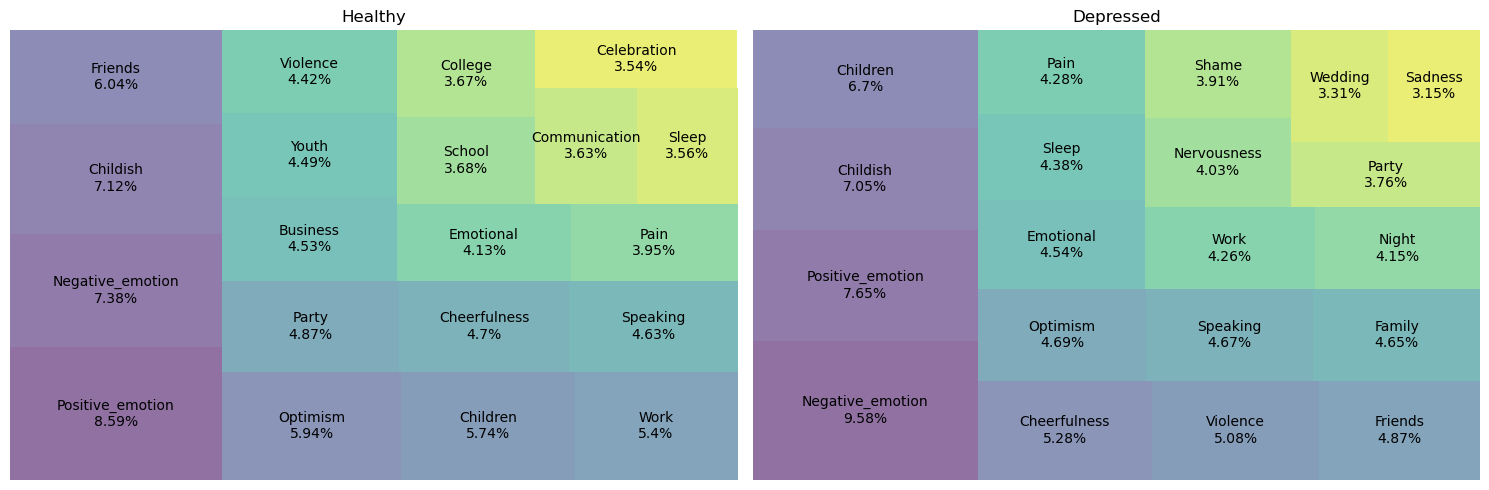

In [121]:
import matplotlib.pyplot as plt
import squarify
import pandas as pd
import seaborn as sns

# Assuming 'df' is your DataFrame
df['index'] = df['index'].str.capitalize()

# Sort DataFrame by column '0' and '1' in descending order
df_sorted_0 = df.sort_values(by=0, ascending=False)[:20]
df_sorted_1 = df.sort_values(by=1, ascending=False)[:20]

# Filter out rows where '0' or '1' is zero
df_sorted_0 = df_sorted_0[df_sorted_0[0] > 0]
df_sorted_1 = df_sorted_1[df_sorted_1[1] > 0]

# Calculate percentages for each class
df_sorted_0['percentage'] = (df_sorted_0[0] / df_sorted_0[0].sum()) * 100
df_sorted_1['percentage'] = (df_sorted_1[1] / df_sorted_1[1].sum()) * 100

# Create labels with class and percentages for column '0' and '1'
df_sorted_0['label'] = df_sorted_0['index'] + "\n" + df_sorted_0['percentage'].round(2).astype(str) + "%"
df_sorted_1['label'] = df_sorted_1['index'] + "\n" + df_sorted_1['percentage'].round(2).astype(str) + "%"

# Plot them usin
# Plot them using a squarify plot
fig, ax = plt.subplots(1, 2, figsize=(15,5))

# For column '0'
colors = sns.color_palette('viridis', len(df_sorted_0))
squarify.plot(sizes=df_sorted_0[0], label=df_sorted_0['label'], alpha=0.6, ax=ax[0], color=colors)
ax[0].set_title('Healthy', fontsize=12)
ax[0].axis('off')

# For column '1'
colors = sns.color_palette('viridis', len(df_sorted_1))
squarify.plot(sizes=df_sorted_1[1], label=df_sorted_1['label'], alpha=0.6, ax=ax[1], color=colors)
ax[1].set_title('Depressed', fontsize=12)
ax[1].axis('off')

plt.savefig("word_class.png")
plt.tight_layout()
plt.show()



#### Define the param_grids

In [124]:
models = [
    ('Logistic Regression', LogisticRegression(class_weight='balanced'), {
        'classifier__C': [0.1, 1, 5, 10],
        'classifier__penalty': ['none', 'l2']
    }),
    ('Random Forest', RandomForestClassifier(class_weight='balanced'), {
        'classifier__n_estimators': [10, 100, 200, 300],
        'classifier__max_depth': [None, 5, 10],
        'classifier__criterion': ['gini', 'entropy']
    }),
    ('Support Vector Machine', SVC(class_weight='balanced', probability=True), {
        'classifier__C': [0.1, 1, 5, 10],
        'classifier__gamma': ['scale', 'auto'],
        'classifier__kernel': ['rbf', 'linear']
    })
]

# Define the pipeline for text classification
pipeline = Pipeline([
    ('vectorizer', StandardScaler()),  # Convert text into numerical features
    ('pca', PCA(n_components=0.9)), #Feature selector sencillo
    ('classifier', None)  # Placeholder for the classifier
])


In [125]:
from tqdm import tqdm 

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

def train_questions(data, models, pipeline):
    # Train and evaluate each model

    results_df = pd.DataFrame(columns=['Question_id',"Question",'Best Model','Train F1','Train Recall','Train AUC','Test F1','Test Recall','Test AUC'])

    for question in tqdm(data.question.unique()):
        best_model = None
        
        best_f1 = 0.0
        best_recall = 0.0
        best_auc = 0.0
        
        best_f1_mean = 0.0
        best_recall_mean = 0.0
        best_auc_mean = 0.0
        
        question_text = data.loc[data.question==question].question_text.unique()[0]
        question_data = preprocess(data.loc[data.question==question])

        kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        x_train, y_train, x_test, y_test = split_dataset(question_data)

        for model_name, model, param_grid in models:
            pipeline.set_params(classifier=model)
            grid_search = GridSearchCV(pipeline, param_grid, scoring=["f1","roc_auc","recall"], cv=kfold, n_jobs=-1, refit='f1')
            grid_search.fit(x_train, y_train)

            y_pred = grid_search.predict(x_test)

            f1 = f1_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            auc = roc_auc_score(y_test, y_pred)

            if f1 >= best_f1:
                
                best_model = model_name

                best_f1 = f1
                best_recall = recall
                best_auc = auc
               
                best_f1_mean = grid_search.best_score_
                best_recall_mean = grid_search.cv_results_['mean_test_recall'][grid_search.best_index_]
                best_auc_mean = grid_search.cv_results_['mean_test_roc_auc'][grid_search.best_index_]

        results_df = results_df.append({
            'Question_id': question,
            'Question': question_text,
            'Best Model': best_model,
            'Train F1': best_f1_mean,
            'Train Recall': best_recall_mean,
            'Train AUC': best_auc_mean,
            'Test F1': best_f1,
            'Test Recall': best_recall,
            'Test AUC': best_auc
        }, ignore_index=True)

    return results_df.sort_values(by='Question_id', ascending=True).reset_index(drop=True)


In [126]:
results_df = train_questions(data,models,pipeline)

  0%|          | 0/13 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWar

In [142]:
results_df

,Question_id,Question,Best Model,Train F1,Train Recall,Train AUC,Test F1,Test Recall,Test AUC
0,1,how are you doing today,Logistic Regression,0.482143,0.659722,0.607697,0.416667,0.625000,0.550595
1,2,when was the last time you argued with someone...,Random Forest,0.255613,0.215278,0.517234,0.250000,0.250000,0.475000
2,3,how are you at controlling your temper,Support Vector Machine,0.560577,0.822222,0.671429,0.476190,0.555556,0.583333
3,4,what are you most proud of in your life,Logistic Regression,0.495932,0.566667,0.618663,0.545455,0.750000,0.675000
4,5,how easy is it for you to get a good night's s...,Support Vector Machine,0.487492,0.557143,0.662066,0.600000,0.857143,0.761905
5,6,have you been diagnosed with depression,Random Forest,0.316979,0.250000,0.480159,0.444444,0.333333,0.641667
6,7,have you ever been diagnosed with p_t_s_d,Logistic Regression,0.319577,0.228938,0.574842,0.400000,0.285714,0.616541
7,8,what did you study at school,Support Vector Machine,0.497007,0.700000,0.571050,0.461538,0.750000,0.559211
8,9,how would your best friend describe you,Support Vector Machine,0.483081,0.615385,0.585203,0.400000,0.428571,0.582707
9,10,how have you been feeling lately,Logistic Regression,0.383023,0.452381,0.530722,0.400000,0.571429,0.535714
